# Compare models trained with different features

In [10]:
#imports 
import numpy as np 
import pandas as pd 
import pickle5
import glob
import matplotlib.pyplot as plt

import tensorflow as tf
import format_data
import random

from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

2022-11-14 15:17:09.792501: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 15:17:10.055872: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-14 15:17:11.292041: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/manual/python/39/share/main:/cm/shared/apps/manual/python/39/lib:/cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64:/cm/local/apps/gcc/10.2.0/lib:/cm/local/apps/gcc/10.2

In [11]:
#import the d/home/
#need to read in training genomes - manipulate such that we are reading in just some consistent set of training data 
file = open('/home/grig0076/phispy_phrog_pickles/phrogtrainingdata_phrogs_fourormore.pkl','rb')
all_data = pickle5.load(file)
file.close()

In [50]:
def cutoff_youdens_j(fpr,tpr,thresholds):
    j_scores = tpr-fpr
    j_ordered = sorted(zip(j_scores,thresholds))
    #print(j_ordered)
    return j_ordered[-1][1]

In [5]:
#generate dictionary 
annot = pd.read_csv('/home/grig0076/LSTMs/phrog_annot_v4.tsv', sep = '\t')

#hard-codedn dictionary matching the PHROG cateogories to an integer value 
one_letter = {'DNA, RNA and nucleotide metabolism' : 4,
     'connector' : 2,
     'head and packaging' : 3,
     'integration and excision': 1,
     'lysis' : 5,
     'moron, auxiliary metabolic gene and host takeover' : 6,
     'other' : 7,
     'tail' : 8,
     'transcription regulation' : 9,
     'unknown function' :  0}

#use this dictionary to generate an encoding of each phrog
phrog_encoding = dict(zip([str(i) for i in annot['phrog']], [one_letter.get(c) for c in annot['category']]))

#add a None object to this dictionary which is consist with the unknown 
phrog_encoding[None] = one_letter.get('unknown function')

### Compare training loss across replicates

In [7]:
base = '/home/grig0076/grid_search/all_not_unbiased_features/' 
all_files = glob.glob(base + '*') 

history = [a for a in all_files if 'pkl' in a]

In [11]:
all_history = [h for h in history if 'none' not in h and 'strand' not in h]
strand_history = [h for h in history if 'strand' in h]
none_history = [h for h in history if 'none' in h]

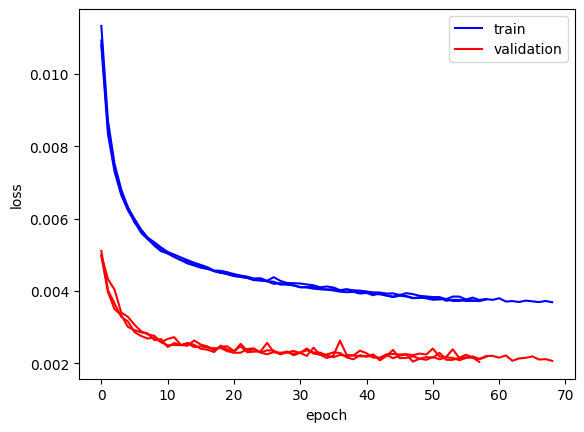

best loss: 0.0020402336958795786
best model:/home/grig0076/grid_search/all_not_unbiased_features/all_nobias_all._features.3_all_features_history.pkl


In [19]:
best_model = '' 
best_loss = 1 

for h in all_history: 
    file = open(h, 'rb') 
    h_dict = pickle5.load(file) 
    file.close() 
        
    plt.plot(h_dict[ 'loss' ][1:], color = 'blue')
    plt.plot(h_dict[ 'val_loss' ][1:], color = 'red')

    plt.xlabel( 'epoch' )
    plt.ylabel('loss') 
    plt.legend([ 'train' , 'validation' ], loc= 'upper right' )
    
    if np.min(h_dict[ 'val_loss' ][1:]) < best_loss: 
        best_loss = np.min(h_dict[ 'val_loss' ][1:])
        best_model = h 
        
plt.show()
print('best loss: ' + str(best_loss))
print('best model:' + best_model)

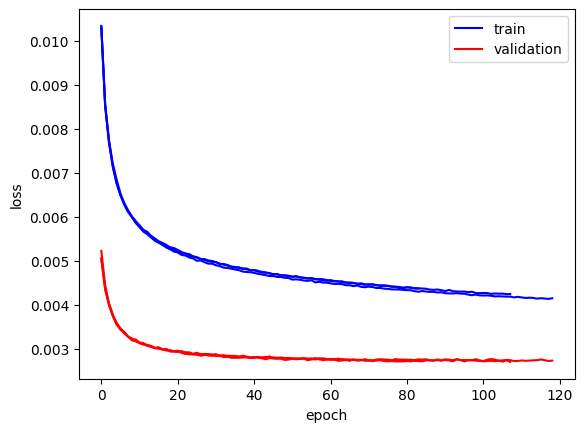

best loss: 0.0027008892502635717
best model:/home/grig0076/grid_search/all_not_unbiased_features/all_nobias_strand._features.3_strand_features_history.pkl


In [21]:
best_model = '' 
best_loss = 1 

for h in strand_history: 
    file = open(h, 'rb') 
    h_dict = pickle5.load(file) 
    file.close() 
        
    plt.plot(h_dict[ 'loss' ][1:], color = 'blue')
    plt.plot(h_dict[ 'val_loss' ][1:], color = 'red')

    plt.xlabel( 'epoch' )
    plt.ylabel('loss') 
    plt.legend([ 'train' , 'validation' ], loc= 'upper right' )
    
    if np.min(h_dict[ 'val_loss' ][1:]) < best_loss: 
        best_loss = np.min(h_dict[ 'val_loss' ][1:])
        best_model = h 
        
plt.show()
print('best loss: ' + str(best_loss))
print('best model:' + best_model)

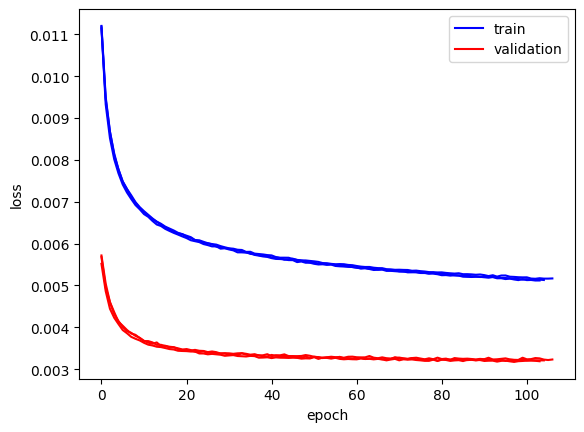

best loss: 0.003173807403072715
best model:/home/grig0076/grid_search/all_not_unbiased_features/all_nobias_none._features.2_none_features_history.pkl


In [22]:
best_model = '' 
best_loss = 1 

for h in none_history: 
    file = open(h, 'rb') 
    h_dict = pickle5.load(file) 
    file.close() 
        
    plt.plot(h_dict[ 'loss' ][1:], color = 'blue')
    plt.plot(h_dict[ 'val_loss' ][1:], color = 'red')

    plt.xlabel( 'epoch' )
    plt.ylabel('loss') 
    plt.legend([ 'train' , 'validation' ], loc= 'upper right' )
    
    if np.min(h_dict[ 'val_loss' ][1:]) < best_loss: 
        best_loss = np.min(h_dict[ 'val_loss' ][1:])
        best_model = h 
        
plt.show()
print('best loss: ' + str(best_loss))
print('best model:' + best_model)

### Plot ROC curve for each model and AUC

In [28]:
#loop through all the proteins  
protein_file = '/home/grig0076/grid_search/all_not_unbiased_features/all_nobias_all._features.3_all_test_prophage_ids.txt'
model_file = '/home/grig0076/grid_search/all_not_unbiased_features/all_nobias_all._features.3_all_features_trained_LSTMbest_val_accuracy.h5'
    
#load in the model 
model  = tf.keras.models.load_model(model_file)
protein_ids = pd.read_csv(protein_file, header = None)[0].to_list()  
    
#get the encodings and features 
prophage_dict = dict(zip(protein_ids, [all_data.get(p) for p in protein_ids]))
test_encodings, test_features = format_data.format_data(prophage_dict, phrog_encoding) 

In [37]:
num_functions = len(one_letter)
n_features = num_functions + len(test_features[0]) 
max_length = 120

categories = [dict(zip(list(one_letter.values()), list(one_letter.keys()))).get(i) for i in range(1,num_functions)]

In [47]:
prob_list = [[] for i in range(num_functions - 1)] 
cat_list = [[] for i in range(num_functions - 1)]

all_prob_list = []  
all_cat_list = [] 

for i in range(3000): 
    
    idx = random.randint(1, len(test_encodings[i]) -1) #don't include ends
        
    #make sure that the mask is not an uknown category 
    while test_encodings[i][idx] == 0: 
        idx = random.randint(1, len(test_encodings[i]) -1)
    
    X, y = format_data.generate_example(test_encodings[i], test_features[i], num_functions, n_features, max_length, idx) 
    yhat = model.predict(X, verbose = 0) 
        
    #if [np.argmax(i) for i in yhat[0]][idx] == [np.argmax(i) for i in y[0]][idx]: 
    correct_category = np.argmax(y[0][idx])
    
    cat_list[correct_category-1].append(1) 
    prob_list[correct_category-1].append(yhat[0][idx][correct_category]) 
            
    #add the 'rest' 
    cat_list[correct_category - 1].append(0) 
    prob_list[correct_category - 1].append(1 - yhat[0][idx][correct_category]) 
    
    #append to all lists 
    all_prob_list.append(yhat[0][idx])  #needs to be from one onwards otherwise includes probability of being predicted to be unknown 
    all_cat_list.append(correct_category)

integration and excision
AUC: 0.94087093981708
Youdens J: 0.5686318278312683
connector
AUC: 0.9952554378696247
Youdens J: 0.5060681104660034
head and packaging
AUC: 0.9904798185941043
Youdens J: 0.544630765914917
DNA, RNA and nucleotide metabolism
AUC: 0.9574930563941553
Youdens J: 0.6528038382530212
lysis
AUC: 0.9825351401397189
Youdens J: 0.5782189965248108
moron, auxiliary metabolic gene and host takeover
AUC: 0.9341361108492789
Youdens J: 0.5134498476982117
other
AUC: 0.9321039710650102
Youdens J: 0.7906308770179749
tail
AUC: 0.9910379369465803
Youdens J: 0.7397281527519226
transcription regulation
AUC: 0.9761450452523962
Youdens J: 0.6509854197502136


Text(0, 0.5, 'False Negative Rate')

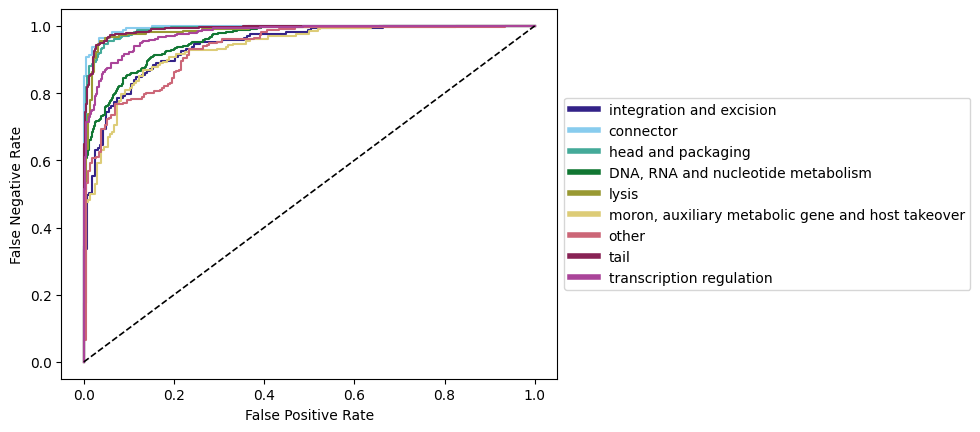

In [51]:
colors = ["#332288", "#88CCEE", "#44AA99", "#117733", "#999933", "#DDCC77", "#CC6677", "#882255", "#AA4499"] 
categories = [dict(zip(list(one_letter.values()), list(one_letter.keys()))).get(i) for i in range(1,num_functions)]
threshold_list = []

for i in range(num_functions-1):
    fpr, tpr, threshold = roc_curve(cat_list[i], prob_list[i])
    auc = roc_auc_score(cat_list[i], prob_list[i])
    print(categories[i]) 
    print('AUC: '+ str(auc))
    print('Youdens J: ' + str(cutoff_youdens_j(fpr, tpr, threshold)))
    plt.plot(fpr, tpr, color = colors[i], label = categories[i])
    
    threshold_list.append(cutoff_youdens_j(fpr, tpr, threshold))
    
leg = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.plot([0, 1], [0, 1], color="black", lw=1.2, linestyle="--")

for line in leg.get_lines():
    line.set_linewidth(4.0)
    
plt.xlabel('False Positive Rate')
plt.ylabel('False Negative Rate')

In [65]:
#confusion matrix
prediction_mat = np.zeros((num_functions - 1, num_functions-1))
category_predict_occurence = np.zeros(num_functions - 1) 

#create vectors to store true_positives, false positives, true negatives and false negatives 
true_positive = np.zeros(num_functions - 1) 
false_positive = np.zeros(num_functions - 1) 
true_negative = np.zeros(num_functions - 1) 
false_negative = np.zeros(num_functions - 1) 

for i in range(len(all_prob_list)):
    
    if np.max(all_prob_list[i]) > threshold_dict.get(np.argmax(all_prob_list[i])):
        
        if all_cat_list[i] == np.argmax(all_prob_list[i]):
            
            true_positive[all_cat_list[i] -1] += 1 
            
        else:
        
            false_positive[np.argmax(all_prob_list[i])-1] += 1
            false_negative[all_cat_list[i] -1] += 1
            
    else:
        
        false_negative[all_cat_list[i] -1] += 1
        
precision = true_positive/(true_positive + false_positive)
recall = true_positive/(true_positive + false_negative) 
f1 = 2*precision*recall/(precision + recall) 

Text(0, 0.5, 'PHROG category')

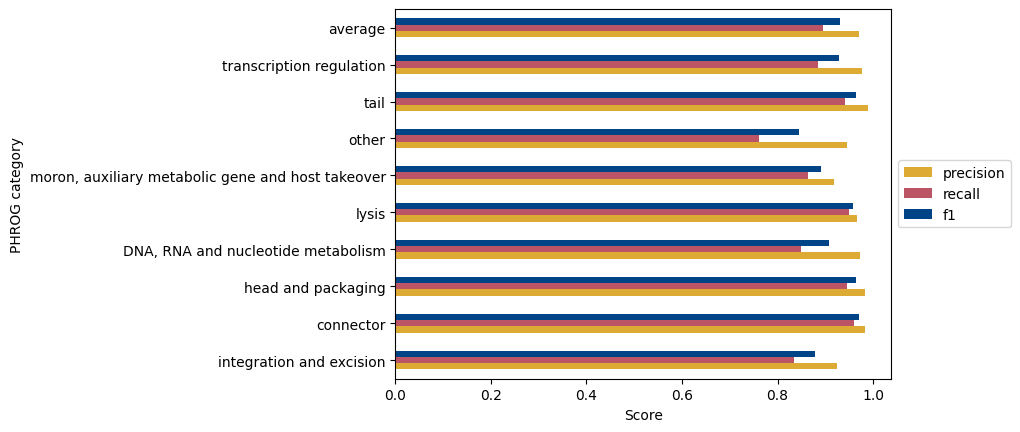

In [66]:
df = pd.DataFrame({'category': categories, 'precision': precision, 'recall': recall, 'f1': f1})

#add an average across the predictions - should this be weighted by category
average_precision = np.sum(true_positive)/(np.sum(true_positive) + np.sum(false_positive)) 
average_recall =  np.sum(true_positive)/(np.sum(true_positive) + np.sum(false_negative))
average_f1 =  2*average_precision*average_recall/(average_precision + average_recall) 
average_df = pd.DataFrame({'category': 'average', 'precision': average_precision, 'recall': average_recall, 'f1': average_f1},  index=[0])
df = df.append(average_df)

ax = df.plot(kind='barh', color = ('#DDAA33', '#BB5566' , '#004488')) #alternative color blind friendly colours ('#66c2a5', '#fc8d62' , '#8da0cb') 
ax.set_yticklabels(df.category)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel("Score")
ax.set_ylabel("PHROG category")

In [ ]:
#add error bars using k-fold cross validation 

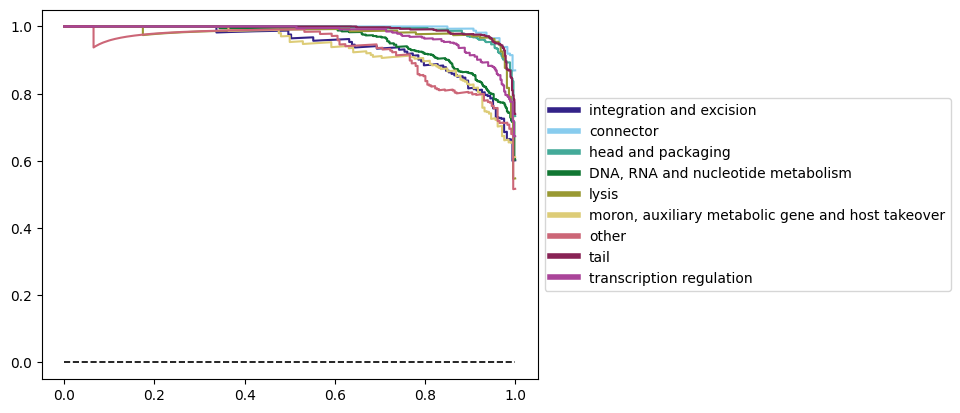

In [48]:
colors = ["#332288", "#88CCEE", "#44AA99", "#117733", "#999933", "#DDCC77", "#CC6677", "#882255", "#AA4499"] 
for i in range(num_functions-1):
    precision, recall, thresholds = precision_recall_curve(cat_list[i], prob_list[i])
    ax = plt.plot(recall, precision, color = colors[i], label = categories[i])
leg = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 0], color="black", lw=1.2, linestyle="--")

for line in leg.get_lines():
    line.set_linewidth(4.0)

In [ ]:
#caculate average one vs all and one vs all AUC statistics 

In [ ]:
#youdens index threshold

In [ ]:
#barplot

In [ ]:
#confusion matrix 

In [71]:
#TRY K-FOLD cross validation

from sklearn.model_selection import KFold

In [3]:
import numpy as np

In [ ]:
#save each of the separate chunks so that they can be used later to check 



In [7]:
kk = np.array(range(10))
kk[kk!=2] #this excludes the second chunk in the validation procedure 

In [43]:
data = '/home/grig0076/phispy_phrog_pickles/phrogtrainingdata_phrogs_fourormore.pkl'
data[:-4]

'/home/grig0076/phispy_phrog_pickles/phrogtrainingdata_phrogs_fourormore'

In [ ]:
#import the d/home/
#need to read in training genomes - manipulate such that we are reading in just some consistent set of training data
data = '/home/grig0076/phispy_phrog_pickles/phrogtrainingdata_phrogs_fourormore.pkl'
file = open(data,'rb')
all_data = pickle5.load(file)
file.close() 

In [39]:
#generate dictionary 
annot = pd.read_csv('/home/grig0076/LSTMs/phrog_annot_v4.tsv', sep = '\t')

#hard-codedn dictionary matching the PHROG cateogories to an integer value 
one_letter = {'DNA, RNA and nucleotide metabolism' : 4,
     'connector' : 2,
     'head and packaging' : 3,
     'integration and excision': 1,
     'lysis' : 5,
     'moron, auxiliary metabolic gene and host takeover' : 6,
     'other' : 7,
     'tail' : 8,
     'transcription regulation' : 9,
     'unknown function' :  0}

#use this dictionary to generate an encoding of each phrog
phrog_encoding = dict(zip([str(i) for i in annot['phrog']], [one_letter.get(c) for c in annot['category']]))

#add a None object to this dictionary which is consist with the unknown 
phrog_encoding[None] = one_letter.get('unknown function')

In [38]:
#randomly shuffle the dictionary 
all_data = format_data.shuffle_dict(all_data)

all_data = format_data.derep_trainingdata(all_data, phrog_encoding) 

TypeError: derep_trainingdata() missing 1 required positional argument: 'phrog_encoding'

In [44]:
n = int(len(all_data)/11) 
k = 11

for i in range(k): 
    
    fold = dict(list(all_data.items())[:i*n])
    
    filename = data[:-4] + str(k) + 'chunk.pkl'
    filehandler = open(filename,"wb")
    pickle5.dump(fold,filehandler)

NameError: name 'pickle' is not defined

In [16]:
len(all_data)*1/kk

/local/grig0076/1448411/ipykernel_2322870/1160758286.py:1: RuntimeWarning: divide by zero encountered in divide
  len(all_data)*1/kk


array([             inf, 2982794.        , 1491397.        ,
        994264.66666667,  745698.5       ,  596558.8       ,
        497132.33333333,  426113.42857143,  372849.25      ,
        331421.55555556])

In [28]:
n = int(len(all_data)/11) 


range(0, 10)

In [30]:
[i for i in range(k)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]